Title

Introduction

Methods and Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

This Cell Loads the data set into Jupyter and cleans the column names into usable formats(ie. "Card Type" to "CardType") and changes the CardType Column from a character column to a factor column.

In [2]:
#Code Here
BankData <- read_csv("https://raw.githubusercontent.com/3deiuah/DSCI-100-Group-Project/main/Customer-Churn-Records.csv")
colnames(BankData)[16] <- "SatisfactionScore"
colnames(BankData)[17] <- "CardType"
colnames(BankData)[18] <- "PointEarned"
BankData <- mutate(BankData,CardType = as_factor(CardType))
head(BankData) #Data set loaded into R, Data Set is already Tidy

Rows: 10000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Surname, Geography, Gender, Card Type
dbl (14): RowNumber, CustomerId, CreditScore, Age, Tenure, Balance, NumOfPro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


RowNumber CustomerId Surname  CreditScore Geography Gender Age Tenure
1 1         15634602   Hargrave 619         France    Female 42  2     
2 2         15647311   Hill     608         Spain     Female 41  1     
3 3         15619304   Onio     502         France    Female 42  8     
4 4         15701354   Boni     699         France    Female 39  1     
5 5         15737888   Mitchell 850         Spain     Female 43  2     
6 6         15574012   Chu      645         Spain     Male   44  8     
  Balance   NumOfProducts HasCrCard IsActiveMember EstimatedSalary Exited
1      0.00 1             1         1              101348.88       1     
2  83807.86 1             0         1              112542.58       0     
3 159660.80 3             1         0              113931.57       1     
4      0.00 2             0         0               93826.63       0     
5 125510.82 1             1         1               79084.10       0     
6 113755.78 2             1         0              149756.71       1     
  Complain SatisfactionScore CardType PointEarned
1 1        2                 DIAMOND  464        
2 1        3                 DIAMOND  456        
3 1        3                 DIAMOND  377        
4 0        5                 GOLD     350        
5 0        5                 GOLD     425        
6 1        5                 DIAMOND  484

In [3]:
BankNA <- sum(is.na(BankData))
BankNA #No NA values in the data set.

[1] 0

We then check if there are any NA values present in the data set, which there are none.

In this specific analysis, we know that certain columns in this data set are not relevant, such as the CustomerId, RowNumber and Surname columns, so this cell removes them.(note: While we would have liked to leave the remaining data, we were running into memory issues, so a  sample is taken to limit the amount of data we have to process)

In [25]:
CleanBankData <- select(BankData, -CustomerId, -RowNumber, -Surname) |> select(Balance,PointEarned,CreditScore) |> rep_sample_n(4000)
head(CleanBankData)

replicate Balance  PointEarned CreditScore
1 1         107499.7 663         640        
2 1         131082.2 802         445        
3 1         158271.7 296         789        
4 1              0.0 266         716        
5 1         137780.7 817         666        
6 1              0.0 658         668

Then to perform our Exploratory Data Analysis, we split the data into training and testing data.

In [5]:
bank_split <- initial_split(CleanBankData, prop = 0.5, strata = CreditScore)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

For our analysis, we wanted to use the Balance and Points earned for a customer to try to predict their credit score, so we calculated the mean and standard deviations for these columns.

In [6]:
Mean_sd_bank <- bank_train |> select(Balance, PointEarned,CreditScore) |> summarize(mean_Balance = mean(Balance),sd_Balance = sd(Balance),mean_Point = mean(PointEarned), 
                                         sd_Point = sd(PointEarned),
                                         mean_Credit = mean(CreditScore),sd_Credit = sd(CreditScore))
Mean_sd_bank

Adding missing grouping variables: `replicate`


replicate mean_Balance sd_Balance mean_Point sd_Point mean_Credit sd_Credit
1 1         73424.04     62038.46   609.529    226.1125 652.3515    95.47914

While we want to use Balance and Points earned to predict Credit Score, we can visualize the relationship between these two variables to see if there is any confounding between the two variables.

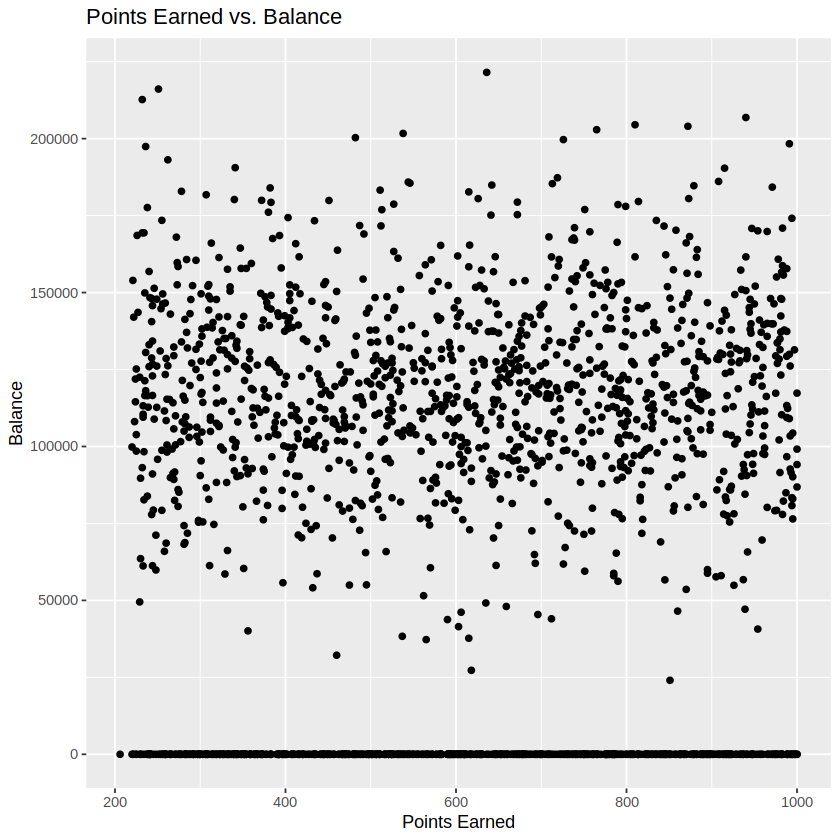

In [26]:
correlation_plot <- bank_train |> ggplot(aes(x = PointEarned,y=Balance)) + geom_point() + ylab("Balance") + xlab("Points Earned") + ggtitle("Points Earned vs. Balance")
correlation_plot

As we can see, there is not a significant relationship between the two variables, so we can rule out any confounding.

Then we can begin the data analysis, first creating a specification for a nearest neighbor regression model. We are tuning our k value in order to ensure a proper fit.

In [8]:
bank_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression")

We can then create a recipe to specify what our model will consider to predict Credit Score. As we are using knn regression, we also scale all of our predictors.

In [9]:
bank_recipe <- recipe(CreditScore ~ Balance+PointEarned, data = bank_train)
bank_knn_recipe <- bank_recipe |> step_scale(all_predictors()) |>
       step_center(all_predictors())

Then we can combine the specification and recipe in a workflow, then fitting the training data in as well.

In [10]:
bank_knn_fit <- workflow() |> add_recipe(bank_knn_recipe) |> add_model(bank_knn_spec) |> fit(data = bank_train)

Warning message:
“tune samples were requested but there were 2000 rows in the data. 1995 will be used.”


We can then tune our model. In this case, we are tuning from 1 to 20 by 2.

In [24]:
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
bank_vfold <- vfold_cv(bank_train,v=5,strata = CreditScore)
bank_results <- bank_knn_fit |> tune_grid(resamples = bank_vfold,grid = gridvals) |> collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
bank_results

neighbors .metric .estimator mean     n std_err  .config              
1 10        rmse    standard   100.9987 5 1.392721 Preprocessor1_Model10

As we can see, the best k value for this data set is 10, which is created and run in the following cell

In [22]:
bank_knn_spec_10 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |> 
       set_engine("kknn") |>
       set_mode("regression")
bank_knn_fit_10 <- workflow() |> add_recipe(bank_knn_recipe) |> add_model(bank_knn_spec_10) |> fit(data = bank_train)

Next, we can plot our predicted credit score over the graphs for balance and Points earned to see how accurate they are.

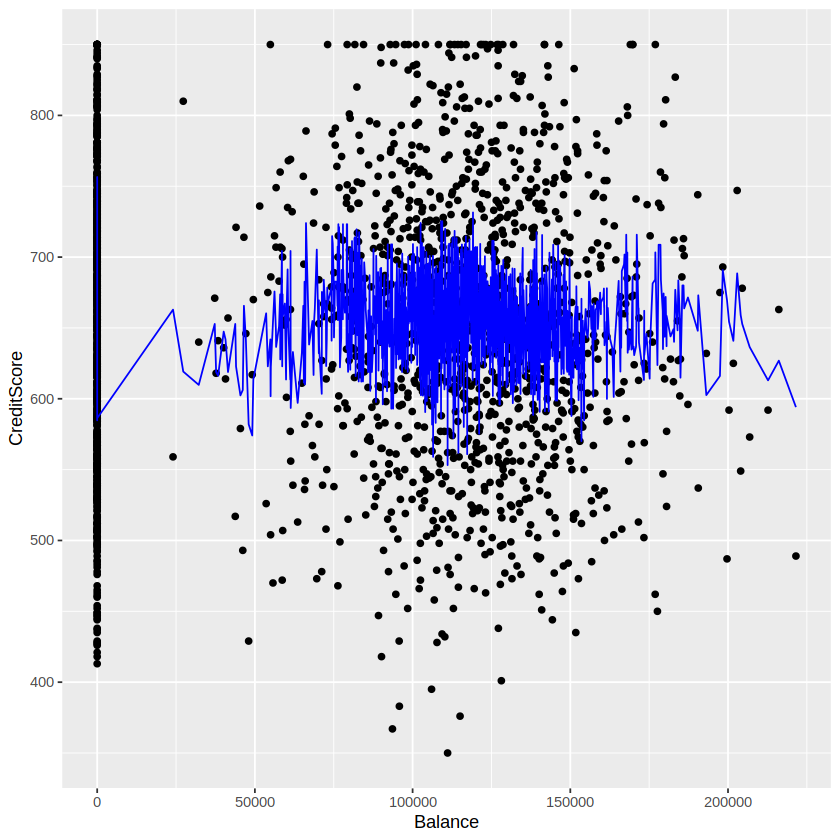

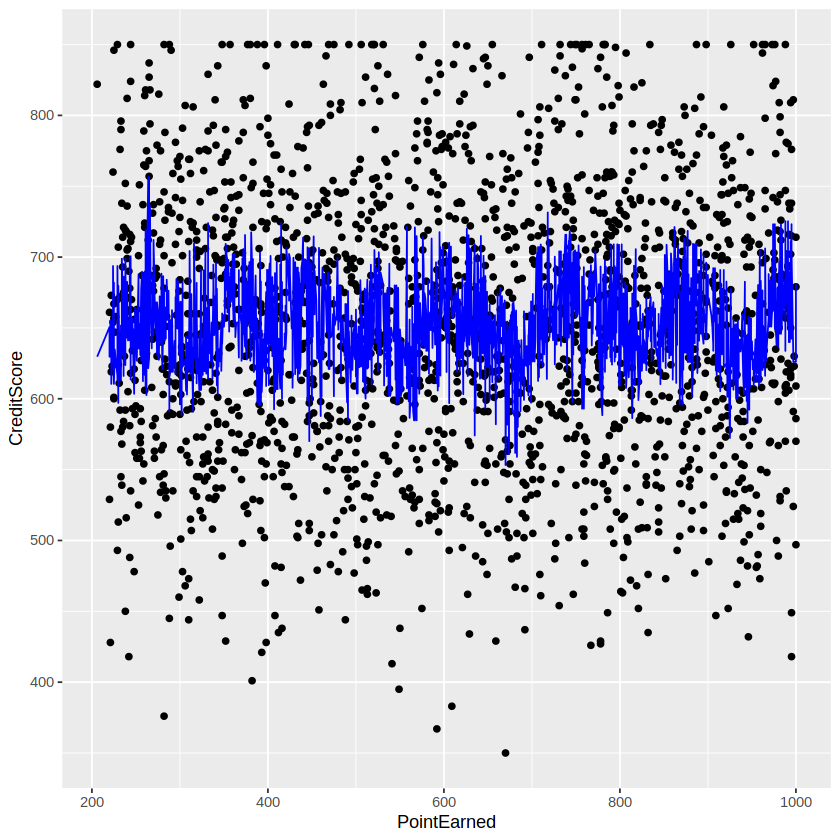

In [23]:
bank_knn_plot1 <- bank_knn_fit_10 |> predict(bank_train) |> bind_cols(bank_train)  |>ggplot(aes(x=Balance,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=Balance,y=.pred),color = "blue")
bank_knn_plot1
bank_knn_plot2 <- bank_knn_fit_10 |> predict(bank_train) |> bind_cols(bank_train)  |>ggplot(aes(x=PointEarned,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=PointEarned,y=.pred),color = "blue")
bank_knn_plot2